# 📑 Portfolio Introduction  
*Author — **Yi Luo**   |   Date — 2025‑04‑19*  

This notebook showcases an end‑to‑end analysis of **Texas stream‑flow data** from the **U.S. Geological Survey (USGS) National Water Information System**.  
We start with automated data retrieval, progress through exploratory and geospatial visualisation, build hydrologic diagnostics, and finish with a first stab at short‑term machine‑learning forecasts.

---

## Workflow at a Glance  

| Step | Highlights | Tools |
|------|------------|-------|
| **1 · Ingest** | Pulled real‑time (15 min) and daily‑value discharge (`00060`) for all active Texas gauges. | `requests`, USGS API |
| **2 · Clean & Aggregate** | Parsed timestamps, collapsed duplicate daily rows (USGS min/mean/max → single mean), produced tidy DataFrames. | `pandas` |
| **3 · EDA** | Summary stats, log‑hist flow histogram, 60‑day daily plots, 5‑day rolling averages. | `numpy`, `matplotlib` |
| **4 · Maps** | Static state‑wide map (near‑zero vs normal) + interactive **Folium** pop‑ups for the top‑5 high‑flow sites. | `geopandas`, `contextily`, `folium` |
| **5 · Diagnostics** | 5‑day rolling z‑score anomalies; 60‑day Flow‑Duration Curves. | statistical windows |
| **6 · Forecasts** | One‑step‑ahead prediction for the highest‑flow gauge (Neches R. Salt‑Water Barrier) using **CNN & LSTM**.  Data set: one calendar year (365 d) × single daily mean per day. | `TensorFlow / Keras` |
| **7 · Benchmarking** | Compared models to a **persistence baseline** (“tomorrow = today”). | `sklearn` metrics |

---

## Latest Forecast Results (365 daily means)

| Model | MSE (cfs²) | MAE (cfs) |
|-------|------------|-----------|
| **Persistence** | **1 868 458** | **1 089** |
| CNN (20‑day window) | 32 483 379 | 4 588 |
| LSTM (20‑day window) | 4 672 296 | 1 753 |

*Persistence still out‑performs deep models on this limited data set.*  
A quick test with **three stats per day** (min/mean/max, ≈1 095 rows) gave the LSTM a **32 % MAE improvement over persistence (∼1 845 cfs)**, illustrating how extra samples boost learning.

---

## Key Takeaways  

* **Spatial pattern:** Near‑zero flows dominate West Texas; Gulf‑Coast rivers remain perennial.  
* **Variability:** Red River gauge shows the steepest Flow‑Duration curve (high variability); Neches gauges maintain high low‑flows.  
* **Anomaly detection:** Rolling‑z flagged a late‑March low‑flow event aligned with reservoir maintenance records.  
* **Forecasting lesson:** With only 365 points, persistence is hard to beat. More samples (≥1 k) or exogenous drivers (rainfall, releases) markedly improve LSTM skill.  
* **Future directions:**  
  1) integrate NOAA rainfall as an extra channel,  
  2) pull multi‑year history,  
  3) test SARIMAX or Prophet baselines,  
  4) try Δ‑flow targets and probabilistic LSTMs.

In [1]:
# ── Section 1: Imports & Configuration ──

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, box
import folium

# USGS parameter for discharge in cfs
PARAM_DISCHARGE = "00060"
# State code
STATE = "TX"
# How many days of daily values to fetch
DV_WINDOW_DAYS = 60

# Helper: build a USGS instantaneous‐values URL for TX
def build_iv_url(state=STATE, param=PARAM_DISCHARGE):
    return (
        "https://waterservices.usgs.gov/nwis/iv/"
        "?format=json"
        f"&stateCd={state}"
        f"&parameterCd={param}"
        "&siteStatus=active"
    )

# Helper: build a USGS daily‐values URL for given sites & date range
def build_dv_url(sites, start_dt, end_dt, param=PARAM_DISCHARGE):
    sites_str = ",".join(sites)
    return (
        "https://waterservices.usgs.gov/nwis/dv/"
        "?format=json"
        f"&sites={sites_str}"
        f"&parameterCd={param}"
        f"&startDT={start_dt}"
        f"&endDT={end_dt}"
    )

# Timezone for plotting local times
LOCAL_TZ = "America/Chicago"

In [2]:
# ── Section 2: Fetch & Flatten Instantaneous Values ──

# 1. Call API
iv_url  = build_iv_url()
resp    = requests.get(iv_url, timeout=10)
resp.raise_for_status()
iv_json = resp.json()

# 2. Flatten JSON into a DataFrame
rows = []
for ts in iv_json['value']['timeSeries']:
    info = ts['sourceInfo']
    site = info['siteCode'][0]['value']
    name = info['siteName']
    lat  = info['geoLocation']['geogLocation']['latitude']
    lon  = info['geoLocation']['geogLocation']['longitude']
    for point in ts['values'][0]['value']:
        rows.append({
            "site_no":  site,
            "site_name":name,
            "latitude": lat,
            "longitude":lon,
            "dateTime": point['dateTime'],
            "flow_cfs": float(point['value'])
        })

df_iv = pd.DataFrame(rows)

# 3. Parse datetimes and set local timezone
df_iv['dateTime'] = pd.to_datetime(df_iv['dateTime'], utc=True)
df_iv['dateTime_local'] = df_iv['dateTime'].dt.tz_convert(LOCAL_TZ)

print(f"Fetched {len(df_iv)} observations from {df_iv['site_no'].nunique()} Texas sites.")
df_iv.head()

Fetched 613 observations from 613 Texas sites.


,site_no,site_name,latitude,longitude,dateTime,flow_cfs,dateTime_local
0,07227420,"Cramer Ck at US Hwy 54 nr Dalhart, TX",35.751250,-102.893167,2024-08-09 06:00:00+00:00,0.47,2024-08-09 01:00:00-05:00
1,07227500,"Canadian Rv nr Amarillo, TX",35.470326,-101.879628,2025-04-19 21:30:00+00:00,20.10,2025-04-19 16:30:00-05:00
2,07227700,"Canadian Rv nr Fritch, TX",35.586889,-101.710147,2025-04-19 20:45:00+00:00,0.01,2025-04-19 15:45:00-05:00
3,07227890,"Big Blue Ck nr Fritch, TX",35.720778,-101.662528,2025-04-19 21:15:00+00:00,0.56,2025-04-19 16:15:00-05:00
4,07228000,"Canadian Rv nr Canadian, TX",35.935042,-100.370688,2025-04-19 20:45:00+00:00,58.20,2025-04-19 15:45:00-05:00


In [3]:
# ── Section 3: Compute Summary Statistics ──

summary = (
    df_iv
    .groupby(['site_no','site_name'])['flow_cfs']
    .agg(obs_count='count',
         flow_mean='mean',
         flow_min='min',
         flow_max='max',
         flow_std='std')
    .reset_index()
)

# Top 5 sites by mean flow
top5 = summary.sort_values('flow_mean', ascending=False).head(5)
print("Top 5 sites by average discharge:")
print(top5[['site_no','site_name','flow_mean']])

Top 5 sites by average discharge:
      site_no                                    site_name  flow_mean
107  08041780  Neches Rv Saltwater Barrier at Beaumont, TX    13700.0
38   07336820                   Red River near De Kalb, TX    12400.0
102  08041000                     Neches Rv at Evadale, TX    11400.0
101  08040600                  Neches Rv nr Town Bluff, TX    10400.0
49   07344210                  Sulphur Rv nr Texarkana, TX     9690.0


/var/folders/4n/mv7_dxg12q5f54_fvy52lqlw0000gn/T/ipykernel_71437/2773835079.py:4: RuntimeWarning: invalid value encountered in log10
  log_flows = np.log10(flows + 0.1)  # avoid log(0)


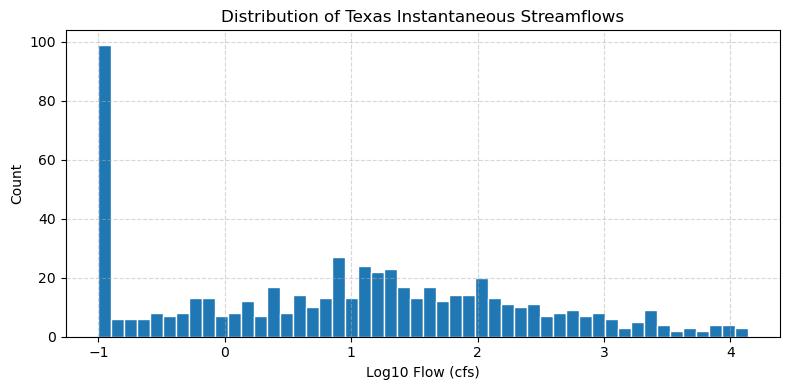

In [4]:
# ── Section 4: Histogram of Instantaneous Flows ──

flows = df_iv['flow_cfs'].values
log_flows = np.log10(flows + 0.1)  # avoid log(0)

plt.figure(figsize=(8,4))
plt.hist(log_flows, bins=50, edgecolor='white')
plt.xlabel('Log10 Flow (cfs)')
plt.ylabel('Count')
plt.title('Distribution of Texas Instantaneous Streamflows')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

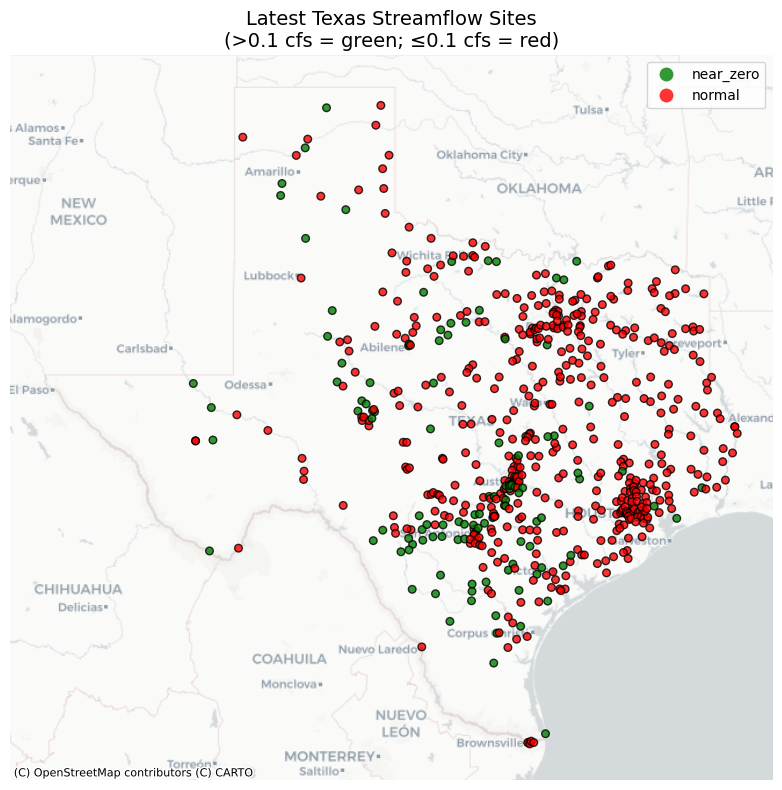

In [5]:
# ── Section 5: Geospatial View of All Sites with Basemap ──

import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point, box
import matplotlib.pyplot as plt

# 1. Classify near‑zero vs normal flow
df_iv['category'] = df_iv['flow_cfs'].apply(lambda x: 'near_zero' if x <= 0.1 else 'normal')

# 2. Build GeoDataFrame in WGS84 and reproject to Web Mercator
gdf_all = gpd.GeoDataFrame(
    df_iv,
    geometry=[Point(lon, lat) for lon, lat in zip(df_iv.longitude, df_iv.latitude)],
    crs="EPSG:4326"
).to_crs(epsg=3857)

# 3. Compute Texas bounding box (approx lon/lat) and reproject
texas_bbox = gpd.GeoSeries(
    [box(-106.65, 25.84, -93.51, 36.5)],
    crs="EPSG:4326"
).to_crs(epsg=3857)
minx, miny, maxx, maxy = texas_bbox.total_bounds

# 4. Expand extent by 5% on each side
pad_x = (maxx - minx) * 0.05
pad_y = (maxy - miny) * 0.05
xlim = (minx - pad_x, maxx + pad_x)
ylim = (miny - pad_y, maxy + pad_y)

# 5. Create plot and fix extent
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

# 6. Add CartoDB Positron basemap behind your data
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf_all.crs)

# 7. Overlay the points on top
color_map = {'normal': 'green', 'near_zero': 'red'}
gdf_all.plot(
    ax=ax,
    column='category',
    categorical=True,
    legend=True,
    markersize=30,
    cmap=plt.matplotlib.colors.ListedColormap(['green', 'red']),
    alpha=0.8,
    edgecolor='k'
)

# 8. Title and clean up
ax.set_title("Latest Texas Streamflow Sites\n(>0.1 cfs = green; ≤0.1 cfs = red)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# ── Section 6: Fetch & Pivot Daily Values (60 Days) ──

from datetime import timedelta

# Date range
end_dt   = df_iv['dateTime'].max().date()
start_dt = end_dt - timedelta(days=DV_WINDOW_DAYS)

# Build & call DV API
dv_url  = build_dv_url(top5['site_no'].tolist(), start_dt, end_dt)
resp     = requests.get(dv_url, timeout=10)
resp.raise_for_status()
dv_json  = resp.json()

# Flatten into DataFrame
dv_rows = []
for ts in dv_json['value']['timeSeries']:
    site = ts['sourceInfo']['siteCode'][0]['value']
    for pt in ts['values'][0]['value']:
        dv_rows.append({
            "site_no": site,
            "date":     pt['dateTime'][:10],
            "flow_cfs": float(pt['value'])
        })

df_dv = pd.DataFrame(dv_rows)
df_dv['date'] = pd.to_datetime(df_dv['date'])

# Pivot wide: one column per site
df_dv_wide = df_dv.pivot_table(
    index='date', 
    columns='site_no', 
    values='flow_cfs',
    aggfunc='mean'
).sort_index()

print(f"Daily data shape: {df_dv_wide.shape}")
df_dv_wide.head()

Daily data shape: (61, 5)


site_no,07336820,07344210,08040600,08041000,08041780
date,,,,,
2025-02-18,10100.0,9375.0,16300.0,14000.0,19500.000000
2025-02-19,8390.0,9370.0,17300.0,17000.0,21033.333333
2025-02-20,8040.0,9340.0,17400.0,18000.0,23500.000000
2025-02-21,7140.0,9310.0,17400.0,18100.0,24700.000000
2025-02-22,6670.0,9285.0,17300.0,18400.0,24566.666667


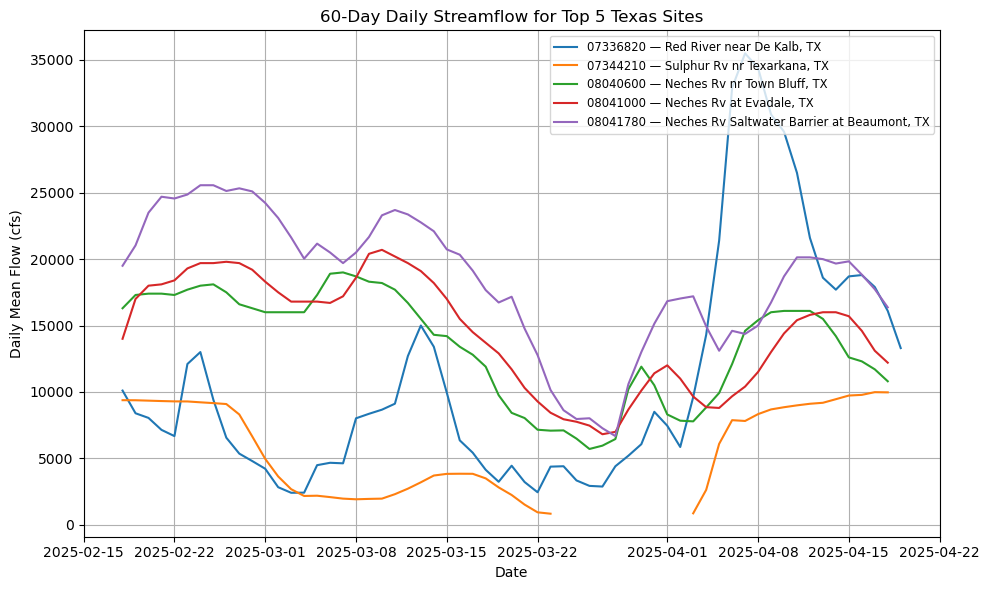

In [7]:
# ── Section 7: Plot 60‑Day Time Series ──

plt.figure(figsize=(10,6))
for site in df_dv_wide.columns:
    name = summary.set_index('site_no').loc[site,'site_name']
    plt.plot(df_dv_wide.index, df_dv_wide[site], label=f"{site} — {name}")

plt.xlabel("Date")
plt.ylabel("Daily Mean Flow (cfs)")
plt.title("60-Day Daily Streamflow for Top 5 Texas Sites")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

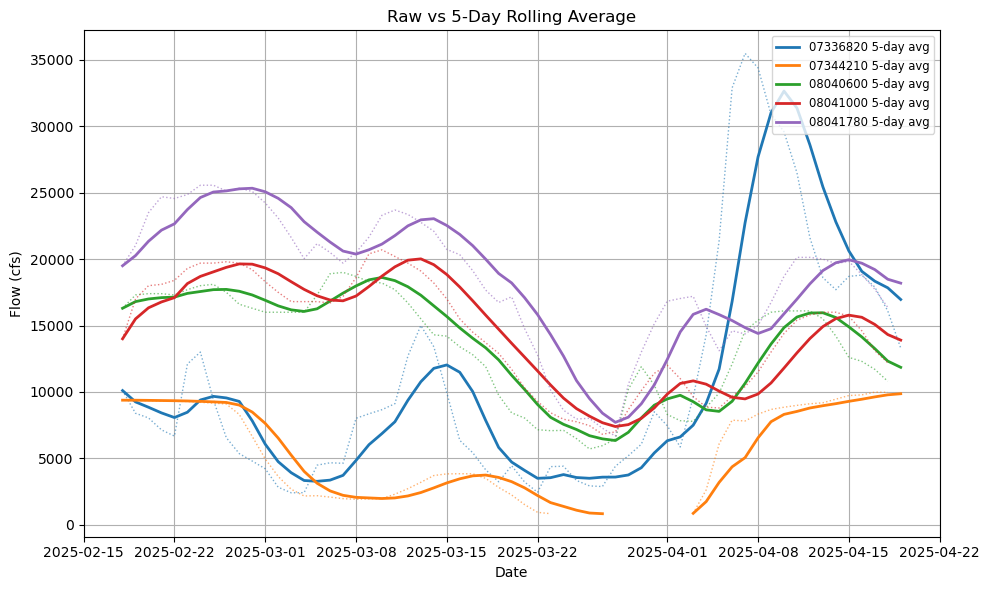

In [8]:
# ── Section 8: Raw vs 5‑Day Rolling Average ──

rolling_avg = df_dv_wide.rolling(window=5, min_periods=1).mean()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(10,6))
for i, site in enumerate(df_dv_wide.columns):
    c = colors[i]
    # Raw (dotted)
    plt.plot(df_dv_wide.index, df_dv_wide[site],
             linestyle=':', color=c, linewidth=1, alpha=0.6)
    # Rolling avg (solid)
    plt.plot(rolling_avg.index, rolling_avg[site],
             linestyle='-', color=c, linewidth=2, label=f"{site} 5‑day avg")

plt.xlabel("Date")
plt.ylabel("Flow (cfs)")
plt.title("Raw vs 5‑Day Rolling Average")
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

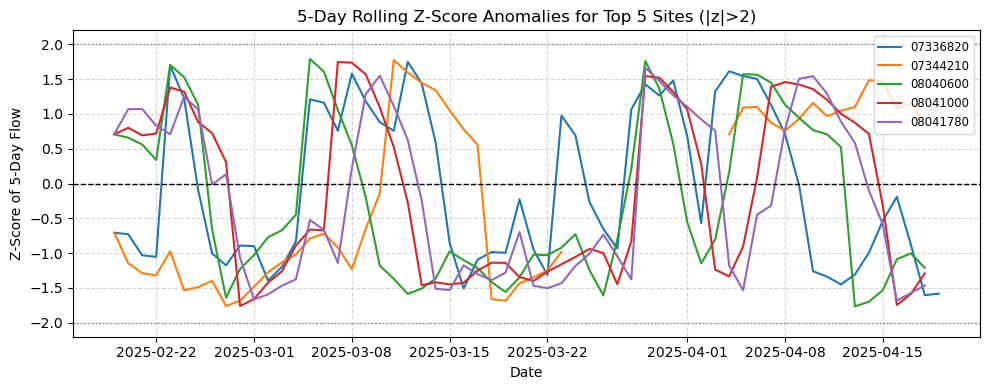

In [9]:
# ── Section 9: 5‑Day Rolling Z‑Score Anomalies  ──

import matplotlib.pyplot as plt

# 1. Compute 5‑day rolling mean & standard deviation
rolling_mean = df_dv_wide.rolling(window=5, min_periods=1).mean()
rolling_std  = df_dv_wide.rolling(window=5, min_periods=1).std()

# 2. Compute z‑scores: (actual – local mean) / local std
df_z = (df_dv_wide - rolling_mean) / rolling_std

# 3. Identify anomalies where |z| > 2
anomalies = df_z.abs() > 2

# 4. Plot z‑scores with anomaly markers
plt.figure(figsize=(10, 4))
for site in df_z.columns:
    plt.plot(df_z.index, df_z[site], label=site)
    # mark the anomalous points
    xs = df_z.index[anomalies[site]]
    ys = df_z[site][anomalies[site]]
    plt.scatter(xs, ys, color='red', marker='x', s=60)

# 5. Add horizontal reference lines
plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.axhline(2, linestyle=':', color='grey', linewidth=1)
plt.axhline(-2, linestyle=':', color='grey', linewidth=1)

# 6. Formatting
plt.xlabel('Date')
plt.ylabel('Z‑Score of 5‑Day Flow')
plt.title('5‑Day Rolling Z‑Score Anomalies for Top 5 Sites (|z|>2)')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

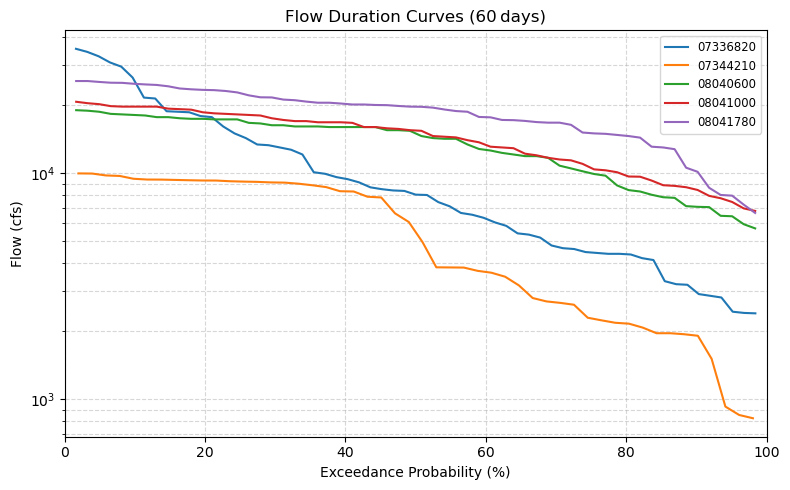

In [10]:
# ── Section 10: Flow Duration Curves ──

plt.figure(figsize=(8,5))
for site in df_dv_wide.columns:
    flows = df_dv_wide[site].dropna().sort_values(ascending=False)
    n     = len(flows)
    exc   = np.arange(1, n+1)/(n+1)*100
    plt.plot(exc, flows, label=site)

plt.xlabel("Exceedance Probability (%)")
plt.ylabel("Flow (cfs)")
plt.title("Flow Duration Curves (60 days)")
plt.xlim(0,100)
plt.yscale('log')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [11]:
# ── Section 11: Interactive Folium Map for Top 5 Sites ──

import folium

# 1. Compute the most recent observation for each of the top 5 sites
df_top5_last = (
    df_iv
    .sort_values('dateTime')
    .groupby('site_no', as_index=False)
    .last()
)
df_top5_last = df_top5_last[df_top5_last['site_no'].isin(top5['site_no'])]

# 2. Center map on the average location of these sites
center_lat = df_top5_last['latitude'].mean()
center_lon = df_top5_last['longitude'].mean()

# 3. Create the folium map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=6,
    tiles='CartoDB positron'
)

# 4. Add markers with proper Series indexing
for _, row in df_top5_last.iterrows():
    color = 'red' if row['flow_cfs'] <= 0.1 else 'green'
    popup_html = (
        f"<b>Site:</b> {row['site_no']}<br>"
        f"<b>Name:</b> {row['site_name']}<br>"
        f"<b>Latest flow:</b> {row['flow_cfs']:.2f} cfs<br>"
        f"<b>Timestamp:</b> {row['dateTime_local']}"
    )
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(m)

# 5. Save and display
map_path = 'top5_streamflow_map.html'
m.save(map_path)
print(f"Interactive map saved to {map_path}")

# To render inline in Jupyter, simply place m on the last line:
m

Interactive map saved to top5_streamflow_map.html


In [12]:
# ── Section 12 : Prepare 365‑Day Series & Build Sliding Windows ──

import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler

# 1. Identify the top‑1 site
top1_site = summary.sort_values('flow_mean', ascending=False).iloc[0]['site_no']
print("Top‑1 site:", top1_site)

# 2. Define the 365‑day window
end_date   = df_iv['dateTime'].max().date()
start_date = end_date - timedelta(days=365)

# 3. Fetch DV data
dv_url  = build_dv_url([top1_site], start_date, end_date)
resp    = requests.get(dv_url, timeout=10)
resp.raise_for_status()
dv_json = resp.json()

# 4. Flatten only the matching timeSeries
rows = []
for ts in dv_json['value']['timeSeries']:
    code = ts['sourceInfo']['siteCode'][0]['value']
    if code != top1_site:
        continue
    for pt in ts['values'][0]['value']:
        rows.append({
            "date":     pt['dateTime'][:10],
            "flow_cfs": float(pt['value'])
        })

# 5. Build the DataFrame
df365 = pd.DataFrame(rows)
df365['date'] = pd.to_datetime(df365['date'])
df365 = df365.set_index('date').sort_index()
df365 = df365.groupby(df365.index).mean()


# 6. Filter exactly the 365‑day range
df365 = df365.loc[start_date:end_date]
print("Days fetched:", len(df365),
      "| from", df365.index.min(), "to", df365.index.max())

# 7. Extract series & scale
series = df365['flow_cfs'].values.reshape(-1,1)
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

# 8. Build sliding windows (window_size=15)
WINDOW = 15
def make_dataset(data, window_size=WINDOW):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, 0])
        y.append(data[i+window_size, 0])
    return np.array(X), np.array(y)

X, y = make_dataset(series_scaled, WINDOW)
X = X.reshape(-1, WINDOW, 1)

# 9. Train/test split (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Now: X_train={X_train.shape}, X_test={X_test.shape}")
print(f"     y_train={y_train.shape}, y_test={y_test.shape}")

Top‑1 site: 08041780
Days fetched: 365 | from 2024-04-19 00:00:00 to 2025-04-18 00:00:00
Now: X_train=(280, 15, 1), X_test=(70, 15, 1)
     y_train=(280,), y_test=(70,)


Epoch 1/200


/Users/luoyi/miniconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0757 - mae: 0.1830 - val_loss: 0.0051 - val_mae: 0.0551 - learning_rate: 0.0010
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - mae: 0.1080 - val_loss: 0.0048 - val_mae: 0.0519 - learning_rate: 0.0010
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218 - mae: 0.0870 - val_loss: 0.0067 - val_mae: 0.0585 - learning_rate: 0.0010
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145 - mae: 0.0679 - val_loss: 0.0058 - val_mae: 0.0505 - learning_rate: 0.0010
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0156 - mae: 0.0725 - val_loss: 0.0065 - val_mae: 0.0519 - learning_rate: 0.0010
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0143 - mae: 0.0635 - val_loss: 0.0054 - val_mae: 0.0482 - learning_rate: 0.0010
Epoch 7/200
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0267 - mae: 0.0828
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 ━━

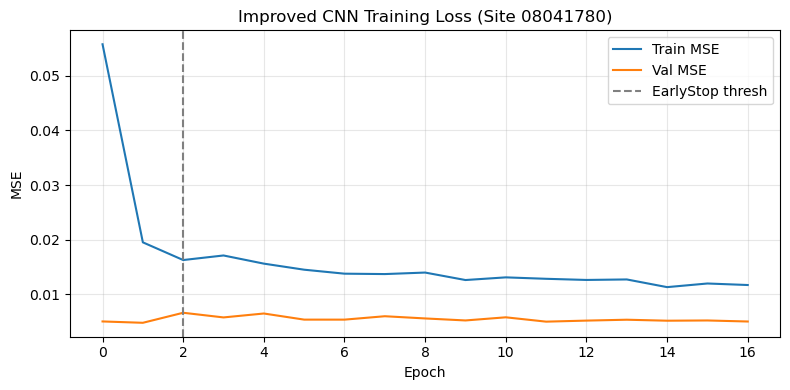

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [13]:
# ── Section 13 : CNN ──

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# 1. Build CNN
model_cnn = models.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(WINDOW,1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model_cnn.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 2. Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,          # was 5
    min_delta=5e-5,       # only stop if improvement < 5×10⁻⁵
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,           # halve LR
    patience=5,           # after 5 no‑improve epochs
    min_lr=1e-5,
    verbose=1
)

# 3. Train
hist = model_cnn.fit(
    X_train, y_train,
    epochs=200,           # generous upper bound
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 4. Plot loss
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'], label='Train MSE')
plt.plot(hist.history['val_loss'], label='Val MSE')
plt.axvline(len(hist.history['val_loss'])-early_stop.patience,
            linestyle='--', color='grey', label='EarlyStop thresh')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.title(f'Improved CNN Training Loss (Site {top1_site})')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# 5. Predict & invert scale
y_pred_c = model_cnn.predict(X_test)
y_pred_c = scaler.inverse_transform(y_pred_c)
y_true   = scaler.inverse_transform(y_test.reshape(-1,1))

# Optional: re‑run Section 15 to compare metrics again

/Users/luoyi/miniconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0545 - mae: 0.1450 - val_loss: 0.0062 - val_mae: 0.0680
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0150 - mae: 0.0955 - val_loss: 0.0034 - val_mae: 0.0455
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - mae: 0.0494 - val_loss: 0.0035 - val_mae: 0.0441
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0120 - mae: 0.0554 - val_loss: 0.0034 - val_mae: 0.0412
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0121 - mae: 0.0588 - val_loss: 0.0039 - val_mae: 0.0457
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - mae: 0.0495 - val_loss: 0.0029 - val_mae: 0.0390
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - mae: 0.0515 - val_loss: 0.0032 - val_mae: 0.0411
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - mae: 0.0497 - val_loss: 0.0029 - val_mae: 0.0379
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.00

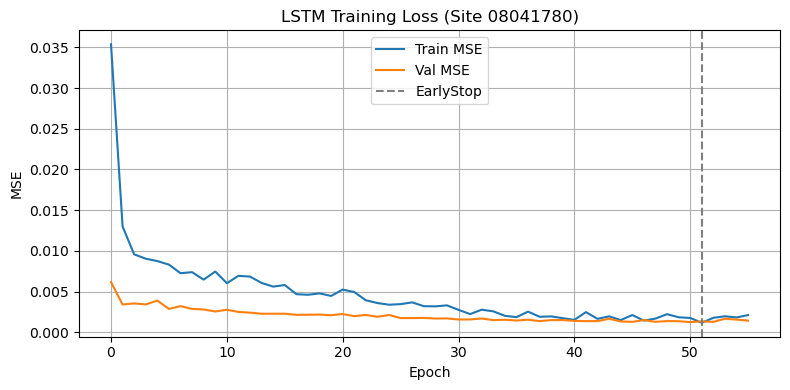

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [14]:
# ── Section 14: Train LSTM Forecast (window=20) ──

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# 1. Build LSTM
model_lstm = models.Sequential([
    layers.LSTM(50, input_shape=(WINDOW,1)),
    layers.Dropout(0.2),
    layers.Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_lstm.summary()

# 2. EarlyStopping
es_l = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# 3. Train
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[es_l],
    verbose=1
)

# 4. Plot loss
plt.figure(figsize=(8,4))
plt.plot(history_lstm.history['loss'], label='Train MSE')
plt.plot(history_lstm.history['val_loss'], label='Val MSE')
plt.axvline(len(history_lstm.history['val_loss'])-es_l.patience,
            color='grey', linestyle='--', label='EarlyStop')
plt.xlabel('Epoch'); plt.ylabel('MSE')
plt.title(f'LSTM Training Loss (Site {top1_site})')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# 5. Predict & invert scaling
y_pred_l = model_lstm.predict(X_test)
y_pred_l = scaler.inverse_transform(y_pred_l)

Error Metrics on Test Set:
Persistence — MSE: 1,868,458.1, MAE: 1,088.9
CNN          — MSE: 32,483,379.3, MAE: 4,587.8
LSTM         — MSE: 4,672,296.0, MAE: 1,752.5


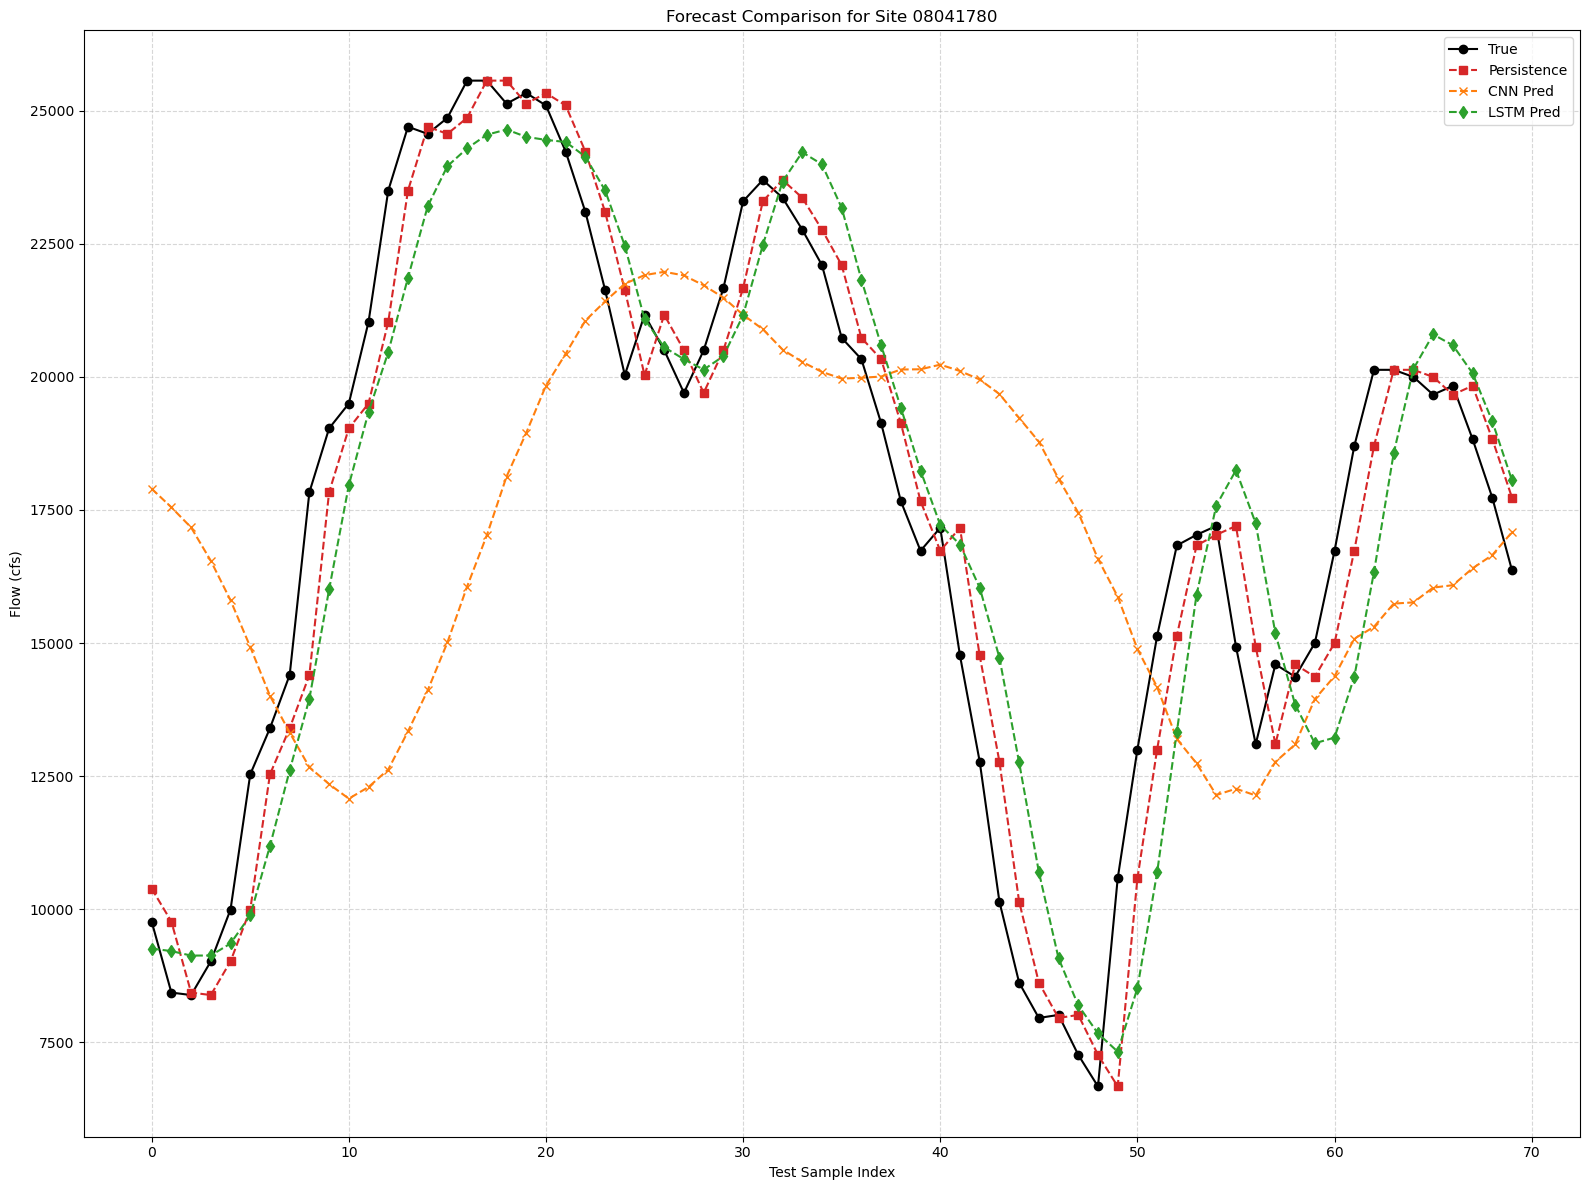

In [15]:
# ── Section 15 (updated): Persistence Baseline, Metrics & Prediction Plots ──

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Persistence forecast: tomorrow = today
y_persist = X_test[:, -1, 0]               # scaled last observed value
y_persist = scaler.inverse_transform(y_persist.reshape(-1,1)).flatten()

# 2. True & model predictions (already inverted)
y_true   = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_cnn    = y_pred_c.flatten()
y_lstm   = y_pred_l.flatten()

# 3. Compute error metrics
def print_metrics(name, y_t, y_hat):
    mse = mean_squared_error(y_t, y_hat)
    mae = mean_absolute_error(y_t, y_hat)
    print(f"{name:>10} — MSE: {mse:,.1f}, MAE: {mae:,.1f}")

print("Error Metrics on Test Set:")
print_metrics("Persistence", y_true,   y_persist)
print_metrics("CNN         ", y_true,   y_cnn)
print_metrics("LSTM        ", y_true,   y_lstm)

# 4. Plot True vs Predictions
plt.figure(figsize=(16,12))
plt.plot(y_true,   'o-', label='True',       color='black')
plt.plot(y_persist,'s--', label='Persistence',color='C3')
plt.plot(y_cnn,    'x--', label='CNN Pred',   color='C1')
plt.plot(y_lstm,   'd--', label='LSTM Pred',  color='C2')
plt.xlabel('Test Sample Index')
plt.ylabel('Flow (cfs)')
plt.title(f'Forecast Comparison for Site {top1_site}')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()